In [8]:
import os
import nibabel as nib
import numpy as np

def file_to_ndarray(filepath):
    # Check the file extension
    _, file_extension = os.path.splitext(filepath)
    #print(file_extension)
    
    try:
        if file_extension in ['.nii', '.nii.gz', '.gz']:  # Handle gzipped or regular NIfTI files
            # Load the NIfTI file
            nii_img = nib.load(filepath)
            # Convert to ndarray
            data = nii_img.get_fdata()
            #print(f"Loaded NIfTI file: {filepath}")
        else:
            print("Unsupported file format.")
            return None
        
        return data
    
    except Exception as e:
        print(f"An error occurred while processing the file: {e}")
        return None

In [ ]:
filepath = r'C:\Users\acer\Desktop\Project_TMJOA\Data\47-4881 L 2014.nii.gz'

voxel = file_to_ndarray(filepath)
print(voxel.shape)

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def display_array_slice(array3d, axis=0, slice_num=0):
    """
    Display a 2D slice from a 3D numpy array.
    
    Parameters:
    -----------
    array3d : numpy.ndarray
        Input 3D array
    axis : int
        Axis along which to take the slice (0, 1, or 2)
    slice_num : int
        Index of the slice to display
        
    Returns:
    --------
    None (displays the plot)
    """
    # Input validation
    if not isinstance(array3d, np.ndarray) or array3d.ndim != 3:
        raise ValueError("Input must be a 3D numpy array")
    
    if axis not in [0, 1, 2]:
        raise ValueError("Axis must be 0, 1, or 2")
    
    # Get the maximum valid slice number for the chosen axis
    max_slice = array3d.shape[axis] - 1
    if slice_num > max_slice:
        raise ValueError(f"Slice number must be between 0 and {max_slice} for axis {axis}")
    
    # Extract the slice based on the axis
    if axis == 0:
        slice_2d = array3d[slice_num, :, :]
        title = f"Slice {slice_num} along axis 0 (front to back)"
    elif axis == 1:
        slice_2d = array3d[:, slice_num, :]
        title = f"Slice {slice_num} along axis 1 (top to bottom)"
    else:  # axis == 2
        slice_2d = array3d[:, :, slice_num]
        title = f"Slice {slice_num} along axis 2 (left to right)"
    
    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.imshow(slice_2d, cmap='viridis')
    plt.colorbar(label='Value')
    plt.title(title)
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.show()

In [ ]:
# Display different slices
display_array_slice(voxel, axis=0, slice_num=112)  # Show third slice along axis 0
display_array_slice(voxel, axis=1, slice_num=112)  # Show fourth slice along axis 1
display_array_slice(voxel, axis=2, slice_num=112)  # Show fifth slice along axis 2

In [5]:
def compute_histogram(ndarray):
    
    flat_array = ndarray.flatten()

    # Define the bin edges from -4000 to 4000 with a bin size of 10
    bins = np.arange(-4000, 4001, 10)  # 2001 to include the endpoint 2000 in the last bin

    # Compute histogram
    histogram_values, bin_edges = np.histogram(flat_array, bins=bins)

    # Convert histogram values to list
    #histogram_list = histogram_values.tolist()

    return histogram_values, bin_edges


In [ ]:
histogram_list, bin_edges = compute_histogram(voxel)
print(histogram_list[1:])

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.stats import norm

def plot_histogram_peaks_normal(arr, bin_edges, variance1=1.0, variance2=1.0, height=None, distance=1, prominence=None):
    """
    Plot histogram with local peaks and normal distributions centered at the two highest peaks
    
    Parameters:
    -----------
    arr : numpy.ndarray
        1D input array of histogram heights
    bin_edges : numpy.ndarray
        Array of bin edges (should be len(arr) + 1)
    variance1 : float
        Variance for the normal distribution at the highest peak
    variance2 : float
        Variance for the normal distribution at the second highest peak
    height : float or None
        Minimum height of peaks
    distance : int
        Minimum horizontal distance between peaks
    prominence : float or None
        Minimum prominence of peaks
    """
    if len(bin_edges) != len(arr) + 1:
        raise ValueError("bin_edges should have length equal to arr length + 1")
        
    # Find local peaks
    peaks, properties = find_peaks(arr, height=height, distance=distance, prominence=prominence)
    peak_heights = arr[peaks]
    
    # Sort peaks by height
    peak_order = np.argsort(peak_heights)[::-1]
    peaks_sorted = peaks[peak_order]
    heights_sorted = peak_heights[peak_order]
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # Plot histogram bars
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.bar(bin_centers, arr, width=bin_edges[1]-bin_edges[0], 
            alpha=0.5, color='blue', label='Histogram')
    
    # Plot peaks
    peak_x_positions = bin_centers[peaks_sorted]
    plt.scatter(peak_x_positions, heights_sorted, 
                c='red', s=100, label='Local Peaks')
    
    # Add normal distributions for top two peaks
    colors = ['g', 'm']  # green for first peak, magenta for second
    styles = ['--', ':']  # dashed for first peak, dotted for second
    variances = [variance1, variance2]
    
    for i in range(min(2, len(peaks_sorted))):
        peak_center = bin_centers[peaks_sorted[i]]
        peak_height = heights_sorted[i]
        variance = variances[i]
        
        # Create x range centered around the peak
        x_normal = np.linspace(peak_center - 4*np.sqrt(variance), 
                             peak_center + 4*np.sqrt(variance), 
                             200)
        
        # Calculate normal distribution
        y_normal = norm.pdf(x_normal, peak_center, np.sqrt(variance))
        
        # Scale the normal distribution to match peak height
        y_normal = y_normal * (peak_height / np.max(y_normal))
        
        # Plot normal distribution
        plt.plot(x_normal, y_normal, 
                color=colors[i], 
                linestyle=styles[i],
                label=f'Normal at Peak {i+1} (σ²={variance:.1f})', 
                linewidth=2)
        
        # Add peak labels
        plt.annotate(f'Peak {i+1}', 
                    (peak_center, peak_height),
                    xytext=(5, 5),
                    textcoords='offset points')
    
    plt.grid(True, alpha=0.3)
    plt.xlabel('Bin Center')
    plt.ylabel('Count')
    plt.title('Histogram with Local Peaks and Normal Distributions')
    plt.legend()
    plt.show()
    
    return peaks_sorted, heights_sorted, peak_x_positions


In [8]:
histogram_val, bin_edges = compute_histogram(voxel)

In [ ]:
input_y = histogram_val[1:]
input_x = bin_edges[1:]

# Plot with different variances for each peak
peaks, heights, peak_centers = plot_histogram_peaks_normal(
    input_y[300:600],
    input_x[300:601],
    variance1=10000,    # Variance for highest peak
    variance2=22000,    # Variance for second peak
    height=0,      # No minimum height
    distance=20,       # Minimum 5 bins between peaks
    prominence=2000     # Minimum prominence
)

print("Peak bin centers:", peak_centers)
print("Peak heights:", heights)

In [9]:
import numpy as np
from scipy.stats import norm

def rescale_by_probability(image, target_mean, variance):
    """
    Rescale pixel values based on their probability of being the pixel of interest
    under a normal distribution.
    
    Parameters:
    -----------
    image : numpy.ndarray
        Input grayscale image array
    target_mean : float
        The target pixel value (mean of the normal distribution)
    variance : float
        Variance of the normal distribution
    
    Returns:
    --------
    numpy.ndarray
        Rescaled image where each pixel value represents the probability
        of that pixel being the pixel of interest
    """
    # Create a copy to avoid modifying the original
    rescaled = image.copy().astype(float)
    
    # Calculate probability for each pixel value
    probabilities = norm.pdf(rescaled, target_mean, np.sqrt(variance))
    
    # Normalize to [0, 1] range
    probabilities = (probabilities - probabilities.min()) / (probabilities.max() - probabilities.min())
    
    # Optional: Convert to uint8 for visualization (0-255)
    rescaled = (probabilities * 255).astype(np.uint8)
    
    return rescaled

def visualize_rescaling(original, rescaled, target_mean, variance):
    """
    Visualize original and rescaled images side by side
    """
    import matplotlib.pyplot as plt
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Original image
    im1 = ax1.imshow(original, cmap='gray')
    ax1.set_title('Original Image')
    plt.colorbar(im1, ax=ax1)
    
    # Rescaled image
    im2 = ax2.imshow(rescaled, cmap='gray')
    ax2.set_title(f'Probability Map\n(mean={target_mean}, variance={variance})')
    plt.colorbar(im2, ax=ax2)
    
    plt.tight_layout()
    plt.show()

In [ ]:
slice_2d = voxel[112, :, :]

# Target pixel value of 100 with some variance
target_mean = 355
variance = 10000  # Wide variance to show the effect

# Rescale the image
rescaled_image_air = rescale_by_probability(slice_2d, target_mean, variance)

# Visualize results
visualize_rescaling(slice_2d, rescaled_image_air, target_mean, variance)

In [ ]:
slice_2d = voxel[112, :, :]

# Target pixel value of 100 with some variance
target_mean = 935
variance = 22000  # Wide variance to show the effect

# Rescale the image
rescaled_image_bone = rescale_by_probability(slice_2d, target_mean, variance)

# Visualize results
visualize_rescaling(slice_2d, rescaled_image_bone, target_mean, variance)

In [10]:
import numpy as np

def rescale_range(array, a, b):
    """
    Rescale values in range [a,b] to [0,255] based on their position in the range.
    Values outside [a,b] become 0.
    
    Parameters:
    array: np.ndarray - Input array
    a: float - Lower bound of the range
    b: float - Upper bound of the range
    """
    # Create a copy to avoid modifying the original
    result = array.copy()
    
    # Set values outside [a,b] to 0
    result[result < a] = 0
    result[result > b] = 0
    
    # Find values within the range
    mask = (result >= a) & (result <= b)
    
    # Linear rescaling of values in range [a,b] to [0,255]
    result[mask] = ((result[mask] - a) / (b - a)) * 255
    
    return result

# Example usage:
# array = your_array
# rescaled = rescale_range(array, 100, 200)

In [ ]:
slice_2d = voxel[112, :, :]
a = 355
b = 935
adjust_const = 0.25
adjust = int((b-a)*adjust_const)
print(b-a, adjust)

area_of_uncertainty = rescale_range(slice_2d, a+adjust, b-adjust)

In [ ]:
visualize_rescaling(slice_2d, area_of_uncertainty, 0, 0)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have three 2D arrays of the same shape
# Convert them to uint8 if they aren't already
red = rescaled_image_air.astype(np.uint8)
green = area_of_uncertainty.astype(np.uint8)
blue = rescaled_image_bone.astype(np.uint8)

# Combine into RGB
rgb_image = np.stack([red, green, blue], axis=2)

# Display the image
plt.imshow(rgb_image)
plt.axis('off')
plt.show()

In [1]:
import os
import shutil
import random

def split_dataset(source_folder, destination_base, train_ratio=0.7, val_ratio=0.2):
   for split in ['train', 'val', 'test']:
       os.makedirs(os.path.join(destination_base, split), exist_ok=True)
   
   files = [f for f in os.listdir(source_folder) if f.endswith('.nii.gz')]
   random.shuffle(files)
   
   n_files = len(files)
   n_train = int(n_files * train_ratio)
   n_val = int(n_files * val_ratio)
   
   train_files = files[:n_train]
   val_files = files[n_train:n_train + n_val]
   test_files = files[n_train + n_val:]
   
   for files, split in [(train_files, 'train'), 
                       (val_files, 'val'), 
                       (test_files, 'test')]:
       for f in files:
           shutil.copy2(os.path.join(source_folder, f),
                       os.path.join(destination_base, split, f))

# Usage
source_folder = r'D:\Kananat\_Segmented_Preprocessed_expand5px'
destination_folder = r'D:\Kananat\_dataset'
split_dataset(source_folder, destination_folder)

Calculate histogram

In [ ]:
import os
import numpy as np
import nibabel as nib

def process_nii_files(folder_path):
   # Initialize histogram bins
   bins = np.arange(-1500, 2001)  # -1500 to 2000 inclusive
   total_hist = np.zeros(len(bins)-1)
   
   # Process each file
   for filename in os.listdir(folder_path):
       if filename.endswith('.nii.gz'):
           # Load image
           print(filename)
           img = nib.load(os.path.join(folder_path, filename))
           data = img.get_fdata()
           
           # Calculate histogram for this image
           hist, _ = np.histogram(data, bins=bins)
           total_hist += hist
           
           # Clear memory
           del data
           img = None

   return total_hist, bins

# Usage
folder_path = r'D:\Kananat\_dataset\train'
histogram, bin_edges = process_nii_files(folder_path)

# Plot result
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.bar(bin_edges[:-1], histogram, width=1)
plt.xlabel('Voxel Value')
plt.ylabel('Frequency')
plt.title('Voxel Value Distribution')
plt.show()

In [13]:
from sklearn.mixture import GaussianMixture
import numpy as np

def fit_gmm(histogram_data, bin_edges):
   # Create dataset by repeating values according to histogram frequencies
   data = []
   for i in range(len(histogram_data)):
       count = int(histogram_data[i])
       if count > 0:
           # Use bin edges to create uniform samples within each bin
           samples = np.random.uniform(bin_edges[i], bin_edges[i+1], count)
           data.extend(samples)
   
   data = np.array(data).reshape(-1, 1)
   
   # Fit GMM
   gmm = GaussianMixture(n_components=2, random_state=0)
   gmm.fit(data)
   
   return gmm.means_.flatten(), gmm.covariances_.flatten()

In [ ]:
mean, variance = fit_gmm(histogram, bin_edges)
print(mean,variance)

In [ ]:
input_y = histogram
input_x = bin_edges

# Plot with different variances for each peak
peaks, heights, peak_centers = plot_histogram_peaks_normal(
    input_y,
    input_x,
    variance1=23000,    # Variance for highest peak
    variance2=34000,    # Variance for second peak
    height=0,      # No minimum height
    distance=500,       # Minimum 5 bins between peaks
    prominence=50000     # Minimum prominence
)

print("Peak bin centers:", peak_centers)
print("Peak heights:", heights)

In [ ]:
filepath = r'D:\Kananat\_dataset\val\58-42016 L.nii.gz'

voxel = file_to_ndarray(filepath)

slice_2d = voxel[112, :, :]

# Target pixel value of 100 with some variance
target_mean = 313
variance = 23000  # Wide variance to show the effect

# Rescale the image
rescaled_image_air = rescale_by_probability(slice_2d, target_mean, variance)

# Target pixel value of 100 with some variance
target_mean = 875
variance = 34000  # Wide variance to show the effect

# Rescale the image
rescaled_image_bone = rescale_by_probability(slice_2d, target_mean, variance)

a = 313
b = 875
adjust_const = 0.25
adjust = int((b-a)*adjust_const)
print(b-a, adjust)

area_of_uncertainty = rescale_range(slice_2d, a+adjust, b-adjust)

import numpy as np
import matplotlib.pyplot as plt

# Assuming you have three 2D arrays of the same shape
# Convert them to uint8 if they aren't already
red = rescaled_image_air.astype(np.uint8)
green = area_of_uncertainty.astype(np.uint8)
blue = rescaled_image_bone.astype(np.uint8)

# Combine into RGB
rgb_image = np.stack([red, green, blue], axis=2)

# Display the image
plt.imshow(rgb_image)
plt.axis('off')
plt.show()

# Test

In [1]:
import os
import nibabel as nib
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

In [2]:
def file_to_ndarray(filepath):
    # Check the file extension
    _, file_extension = os.path.splitext(filepath)
    #print(file_extension)
    
    try:
        if file_extension in ['.nii', '.nii.gz', '.gz']:  # Handle gzipped or regular NIfTI files
            # Load the NIfTI file
            nii_img = nib.load(filepath)
            # Convert to ndarray
            data = nii_img.get_fdata()
            #print(f"Loaded NIfTI file: {filepath}")
        else:
            print("Unsupported file format.")
            return None
        
        return data
    
    except Exception as e:
        print(f"An error occurred while processing the file: {e}")
        return None

def fit_gmm(histogram_data, bin_edges):
   # Create dataset by repeating values according to histogram frequencies
   data = []
   for i in range(len(histogram_data)):
       count = int(histogram_data[i])
       if count > 0:
           # Use bin edges to create uniform samples within each bin
           samples = np.random.uniform(bin_edges[i], bin_edges[i+1], count)
           data.extend(samples)
   
   data = np.array(data).reshape(-1, 1)
   
   # Fit GMM
   gmm = GaussianMixture(n_components=2, random_state=0)
   gmm.fit(data)
   
   return gmm.means_.flatten(), gmm.covariances_.flatten()

def rescale_by_probability(image, target_mean, variance):
    """
    Rescale pixel values based on their probability of being the pixel of interest
    under a normal distribution.
    
    Parameters:
    -----------
    image : numpy.ndarray
        Input grayscale image array
    target_mean : float
        The target pixel value (mean of the normal distribution)
    variance : float
        Variance of the normal distribution
    
    Returns:
    --------
    numpy.ndarray
        Rescaled image where each pixel value represents the probability
        of that pixel being the pixel of interest
    """
    # Create a copy to avoid modifying the original
    rescaled = image.copy().astype(float)
    
    # Calculate probability for each pixel value
    probabilities = norm.pdf(rescaled, target_mean, np.sqrt(variance))
    
    # Normalize to [0, 1] range
    probabilities = (probabilities - probabilities.min()) / (probabilities.max() - probabilities.min())
    
    # Optional: Convert to uint8 for visualization (0-255)
    rescaled = (probabilities * 255).astype(np.uint8)
    
    return rescaled

def rescale_range(array, a, b):
    """
    Rescale values in range [a,b] to [0,255] based on their position in the range.
    Values outside [a,b] become 0.
    
    Parameters:
    array: np.ndarray - Input array
    a: float - Lower bound of the range
    b: float - Upper bound of the range
    """
    # Create a copy to avoid modifying the original
    result = array.copy()
    
    # Set values outside [a,b] to 0
    result[result < a] = 0
    result[result > b] = 0
    
    # Find values within the range
    mask = (result >= a) & (result <= b)
    
    # Linear rescaling of values in range [a,b] to [0,255]
    result[mask] = ((result[mask] - a) / (b - a)) * 255
    
    return result

mean : [406.15753947 929.98966561], variance : [20529.28860798 25121.72192327]


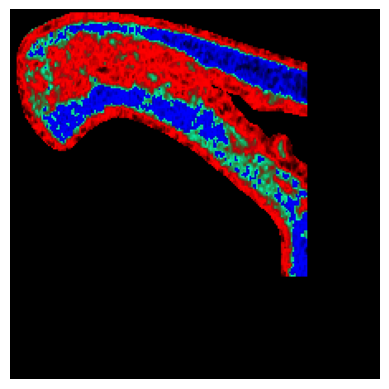

In [3]:
# Load data
filepath = r"C:\Users\acer\Desktop\Data\47-4881 L 2014.nii.gz"
voxel = file_to_ndarray(filepath)

# Compute histogram
flat_array = voxel.flatten()
bins = np.arange(-500, 1500, 1)  # -500 to 1500 size 1

histogram_values, bin_edges = np.histogram(flat_array, bins=bins)
mean, variance = fit_gmm(histogram_values, bin_edges)
print(f"mean : {mean}, variance : {variance}")

slice_2d = voxel[112, :, :]
rescaled_image_air = rescale_by_probability(slice_2d, int(mean[0]), int(variance[0]))
rescaled_image_bone = rescale_by_probability(slice_2d, int(mean[1]), int(variance[1]))

a = mean[0]
b = mean[1]
adjust_const = 0.25
adjust = int((b-a)*adjust_const)
area_of_uncertainty = rescale_range(slice_2d, a+adjust, b-adjust)

red = rescaled_image_air.astype(np.uint8)
green = area_of_uncertainty.astype(np.uint8)
blue = rescaled_image_bone.astype(np.uint8)

# Combine into RGB
rgb_image = np.stack([red, green, blue], axis=2)

# Display the image
plt.imshow(rgb_image)
plt.axis('off')
plt.show()

# Processing folder

In [1]:
import os
import nibabel as nib
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from glob import glob
from PIL import Image

In [6]:
def fit_gmm(histogram_data, bin_edges):
   # Create dataset by repeating values according to histogram frequencies
   data = []
   for i in range(len(histogram_data)):
       count = int(histogram_data[i])
       if count > 0:
            # Use bin edges to create uniform samples within each bin
            samples = np.random.uniform(bin_edges[i], bin_edges[i+1], count)
            data.extend(samples)
   
   data = np.array(data).reshape(-1, 1)
   
   # Fit GMM
   gmm = GaussianMixture(n_components=2, random_state=0)
   gmm.fit(data)

   output_mean = np.sort(gmm.means_.flatten())
   output_variances = gmm.covariances_.flatten()

   if output_mean[0] != gmm.means_.flatten()[0] :
        output_variances = np.flip(gmm.covariances_.flatten())

   return output_mean, output_variances

def rescale_uncertainty(array, a, b):
    # Create a copy to avoid modifying the original
    result = array.copy()
    
    # Set values outside [a,b] to 0
    result[result < a] = 0
    result[result > b] = 0
    
    # Find values within the range
    mask = (result >= a) & (result <= b)
    
    # Linear rescaling of values in range [a,b] to [0,255]
    result[mask] = ((result[mask] - a) / (b - a)) * 255
    
    return result

def rescale_by_probability(image, target_mean, variance):

    # Create a copy to avoid modifying the original
    rescaled = image.copy().astype(float)
    
    # Calculate probability for each pixel value
    probabilities = norm.pdf(rescaled, target_mean, np.sqrt(variance))
    
    # Normalize to [0, 1] range
    probabilities = (probabilities - probabilities.min()) / (probabilities.max() - probabilities.min())
    
    # Optional: Convert to uint8 for visualization (0-255)
    rescaled = (probabilities * 255).astype(np.uint8)
    
    return rescaled

import numpy as np

def pad_image(image, target_size=(224, 224, 3)):
    # Calculate padding amounts
    h_padding = (target_size[0] - image.shape[0]) // 2
    w_padding = (target_size[1] - image.shape[1]) // 2
    
    # Calculate extra padding if odd dimension
    h_extra = (target_size[0] - image.shape[0]) % 2
    w_extra = (target_size[1] - image.shape[1]) % 2
    
    # Pad the image
    padded_image = np.pad(
        image,
        ((h_padding, h_padding + h_extra),  # Height padding
         (w_padding, w_padding + w_extra),  # Width padding
         (0, 0)),                          # No padding for channels
        mode='constant',
        constant_values=0
    )
    
    return padded_image


def slice_extraction(input_folder, output_base_dir):
    nii_files = glob(os.path.join(input_folder, '*.nii.gz'))

    for nii_file in nii_files:
        print(f"Processing : {nii_file}")

        img = nib.load(nii_file)
        data = img.get_fdata()
        
        base_name = os.path.splitext(os.path.splitext(os.path.basename(nii_file))[0])[0]

        flat_array = data.flatten()
        bins = np.arange(-500, 1500, 1)  # -500 to 1500 size 1
        histogram_values, bin_edges = np.histogram(flat_array, bins=bins)

        mean, variance = fit_gmm(histogram_values, bin_edges)
        print(f"mean : {mean}, variance : {variance}")

        for i in range(224):

            if i%10 != 0 :
                continue

            slice_2d = data[i, 0:156 , 0:156]

            empty_count = np.sum(slice_2d < -2000)
            empty_ratio = empty_count / (slice_2d.shape[0] * slice_2d.shape[1])

            if empty_ratio > 0.9:
                continue

            print(f"Extracting slice number : {i}")

            rescaled_image_air = rescale_by_probability(slice_2d, int(mean[0]), int(variance[0]))
            rescaled_image_bone = rescale_by_probability(slice_2d, int(mean[1]), int(variance[1]))

            adjust_const = 0.25
            adjust = int((mean[1]-mean[0])*adjust_const)
            area_of_uncertainty = rescale_uncertainty(slice_2d, mean[0]+adjust, mean[1]-adjust)

            red = rescaled_image_air.astype(np.uint8)
            green = area_of_uncertainty.astype(np.uint8)
            blue = rescaled_image_bone.astype(np.uint8)

            rgb_image = np.stack([red, green, blue], axis=2)

            rgb_image = pad_image(rgb_image)

            out_file = os.path.join(output_base_dir, f"{base_name}_{i:03d}.jpg")

            img = Image.fromarray(rgb_image)
            img.save(out_file)

In [13]:
input_folder = r"D:\Kananat\_dataset\test\erosion_1"
output_base_dir = r"D:\Kananat\_dataset_2d\test\erosion_1"

slice_extraction(input_folder, output_base_dir)

Processing : D:\Kananat\_dataset\test\erosion_1\52-15242 R.nii.gz
mean : [247.95125756 740.14255891], variance : [15395.27118204 34864.93204678]
Extracting slice number : 30
Extracting slice number : 40
Extracting slice number : 50
Extracting slice number : 60
Extracting slice number : 70
Extracting slice number : 80
Extracting slice number : 90
Extracting slice number : 100
Extracting slice number : 110
Extracting slice number : 120
Extracting slice number : 130
Extracting slice number : 140
Extracting slice number : 150
Extracting slice number : 160
Extracting slice number : 170
Extracting slice number : 180
Extracting slice number : 190
Extracting slice number : 200
Processing : D:\Kananat\_dataset\test\erosion_1\54-21497 L 2016.nii.gz
mean : [356.43864997 876.00377692], variance : [19520.96609581 20996.83125927]
Extracting slice number : 50
Extracting slice number : 60
Extracting slice number : 70
Extracting slice number : 80
Extracting slice number : 90
Extracting slice number : 1